In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
def polarCoord_discrete(s1,s2,n=12):
  m=int(np.floor(s1/2)) # radius, assuming s1==s2
  i0=m # center of image
  j0=m # [s1/2,s1/2]
  row=np.zeros((m,n))
  col=np.zeros((m,n))
  dtheta=2.0*np.pi/n
  for j in range(n):
    c=np.cos(j*dtheta)
    s=np.sin(j*dtheta)
    for i in range(m):
      row[i,j]=i0+c*i
      col[i,j]=j0+s*i
  row=np.round(row).astype(np.int32) # discretized
  col=np.round(col).astype(np.int32) # discretized
  #print(row.shape,col.shape,type(row[0,0]),type(col[0,0]))
  return row,col

def getSample(j,I,M,row,col):
  y=[]
  for i in range(row.shape[0]):
    if M[row[i,j],col[i,j]]>0:
      y.append(I[row[i,j],col[i,j]])
    else:
      break
  return np.array(y)

def getSampleFull(j,I,M,row,col):
  y=[]
  for i in range(row.shape[0]):
    y.append(I[row[i,j],col[i,j]])
  return np.array(y)

def BAT_LLM_ridge(t,y):
  x2 = y.shape[0]
  mx=y[0]
  x1=0
  for i in range(1,x2):
    if y[i]>mx:
      mx=y[i]
      x1=i
  TTP=t[x1] # peak value location
  C=y[:x1]
  x0=0
  err=np.finfo(float).max
  for i in range(1,x1-1):
    X=np.ones((x1,2))
    X[:,1]=0
    for j in range(i+1,x1):
      X[j,1]=t[j]-t[i]
    B=np.linalg.inv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(C))
    D=C-X@B
    e=np.transpose(D).dot(D)
    #print('e',e)
    if e<err:
      x0=i
      err=e
  BAT=t[x0]
  md=(np.min(y[:x1])+y[x1])/2
  for i in range(x0,x1):
    if y[i]>=md:
      x_md=i
      break
  MD=t[x_md]
  return BAT,MD,TTP

def findVesselLumen(I,M,num):
  s1,s2=I.shape
  row,col=polarCoord_discrete(s1,s2,num)
  points=[]
  for j in range(num):
    y=getSample(j,I,M,row,col)
    t=np.array(range(y.shape[0]))
    BAT,MD,TTP=BAT_LLM_ridge(t,y)
    if MD>0:
      points.append([col[MD,j],row[MD,j]])
  M1=np.zeros(M.shape,dtype=np.uint8)
  M1[M>0]=255
  cv2.fillPoly(M1,[np.array(points)],1)
  M1[M1==1]=0
  return M1

In [4]:
!git clone https://github.com/hyadamhuang/linearlinearmodel.git /content/linearlinearmodel

Cloning into '/content/linearlinearmodel'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 52 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 185.27 KiB | 1.31 MiB/s, done.
Resolving deltas: 100% (17/17), done.


(160, 160) (160, 160) <class 'numpy.uint8'> <class 'numpy.uint8'>


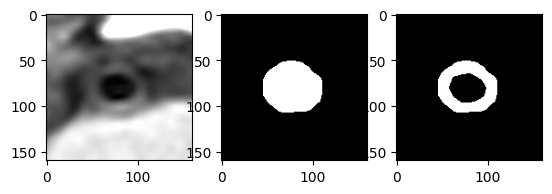

In [5]:
# testing
I=cv2.imread('/content/linearlinearmodel/image.png',cv2.IMREAD_GRAYSCALE)
M=cv2.imread('/content/linearlinearmodel/mask.png',cv2.IMREAD_GRAYSCALE)
print(I.shape,M.shape,type(I[0,0]),type(M[0,0]))
plt.subplot(1, 3, 1)
imshow(I,cmap='gray')
plt.subplot(1, 3, 2)
imshow(M,cmap='gray')
M2=findVesselLumen(I,M,12)
plt.subplot(1, 3, 3)
imshow(M2,cmap='gray')
plt.show()

12 18 25
10 17 29
11 16 23


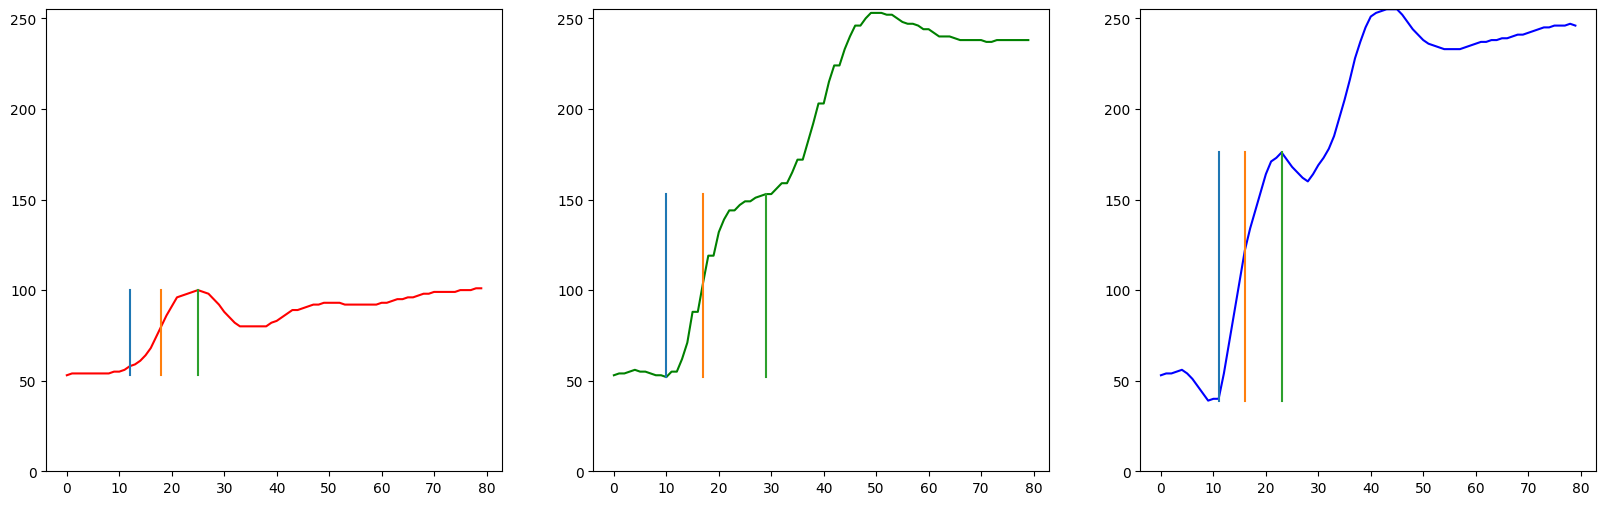

In [7]:
# some radial sampling examples

row,col=polarCoord_discrete(M.shape[0],M.shape[1],16)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
y0=getSampleFull(4,I,M,row,col)
x0=[i for i in range(y0.shape[0])]
axs[0].plot(x0,y0,'r')
y=getSample(4,I,M,row,col)
t=np.array(range(y.shape[0]))
BAT,MD,TTP=BAT_LLM_ridge(t,y)
print(BAT,MD,TTP)
axs[0].plot([BAT,BAT],[np.min(y),np.max(y)])
axs[0].plot([MD,MD],[np.min(y),np.max(y)])
axs[0].plot([TTP,TTP],[np.min(y),np.max(y)])
axs[0].set_ylim([0,255])

y0=getSampleFull(2,I,M,row,col)
x0=[i for i in range(y0.shape[0])]
axs[1].plot(x0,y0,'g')
y=getSample(2,I,M,row,col)
t=np.array(range(y.shape[0]))
BAT,MD,TTP=BAT_LLM_ridge(t,y)
print(BAT,MD,TTP)
axs[1].plot([BAT,BAT],[np.min(y),np.max(y)])
axs[1].plot([MD,MD],[np.min(y),np.max(y)])
axs[1].plot([TTP,TTP],[np.min(y),np.max(y)])
axs[1].set_ylim([0,255])

y0=getSampleFull(0,I,M,row,col)
x0=[i for i in range(y0.shape[0])]
axs[2].plot(x0,y0,'b')
y=getSample(0,I,M,row,col)
t=np.array(range(y.shape[0]))
BAT,MD,TTP=BAT_LLM_ridge(t,y)
print(BAT,MD,TTP)
axs[2].plot([BAT,BAT],[np.min(y),np.max(y)])
axs[2].plot([MD,MD],[np.min(y),np.max(y)])
axs[2].plot([TTP,TTP],[np.min(y),np.max(y)])
axs[2].set_ylim([0,255])

plt.show()